### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import datetime 

### Перевірка застосування графічного процесора

In [2]:
#check if GPU is available
#print(tf.config.list_physical_devices('GPU'))

### Завантажження данних у словник

In [3]:

data = {
    year: {
            "climate": nc.Dataset("data/main/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/main/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [4]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

Одразу позбуваємось даних про вітер на висоті 50 метрів

In [6]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

DATA = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        DATA[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data).drop(["WS50M", "WD50M"], axis=1)


### Статистичні данні стосовно всіх видів викидів

In [17]:
stats = {
    atribute: np.array([])
    for atribute in atributes_polution
}
for val in DATA.values():
    for atribute in atributes_polution:
        stats[atribute] = np.append(stats[atribute], val[atribute])

### Нормалізація данних

In [14]:
normal_stats = {}
for atribute in stats.keys():
    temp = stats[atribute]
    temp = temp - np.min(temp)
    normal_stats[atribute] = temp / np.max(temp)

In [15]:
ranges = [[0, 0.2], [0, 0.15], [0, 0.02], [0, 0.65], [0, 0.18], [0, 0.2], [0, 0.06]]

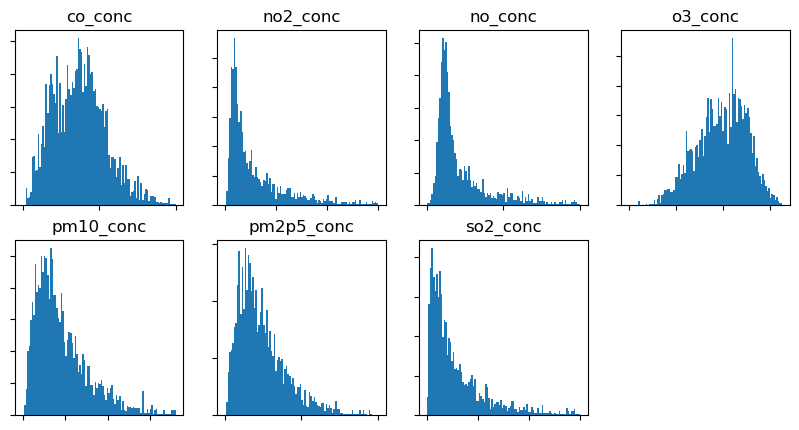

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in normal_stats.keys():
    stat = normal_stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

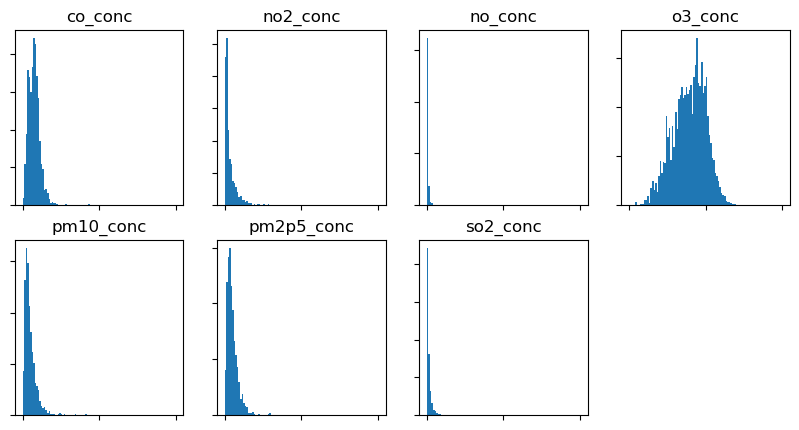

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in normal_stats.keys():
    stat = normal_stats[label]
    ax = axes[i]
    _range = [0, 1]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

### Застосування логарифмічної функції: $\log(1 + x)$

In [45]:
log_stats = {}
for atribute in stats.keys():
    temp = np.log(1 + stats[atribute])
    temp = temp - np.min(temp)
    log_stats[atribute] = temp / np.max(temp)

In [48]:
ranges = [[0, 1]] * 7
ranges[2] = [0, 0.25]

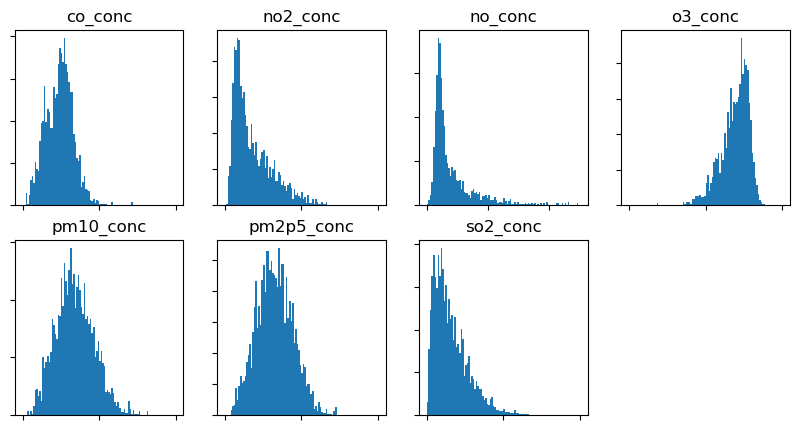

In [49]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in log_stats.keys():
    stat = log_stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

In [20]:
ranges = [[0, 0.5], [0, 0.7], [0, 0.18], [0.4, 0.9], [0, 0.8], [0, 0.72], [0, 0.6]]

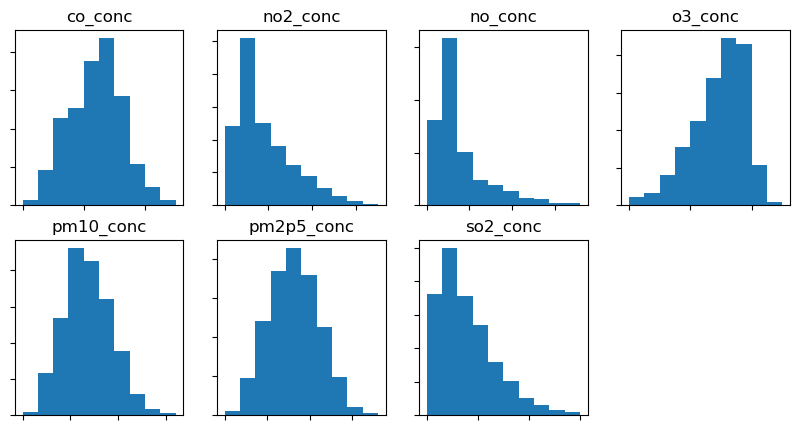

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in log_stats.keys():
    stat = log_stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=10, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

In [13]:
#atributes_climate.remove("WS50M")
atributes_climate.remove("WD50M")

In [14]:
stats = {
    atribute: np.array([])
    for atribute in atributes_climate
}
for val in DATA.values():
    for atribute in atributes_climate:
        stats[atribute] = np.append(stats[atribute], val[atribute])

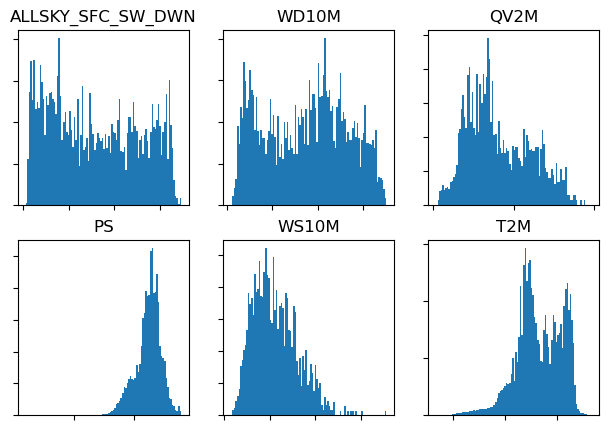

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(2.5 * 3, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in stats.keys():
    stat = stats[label]
    ax = axes[i]
    #_range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
plt.show()

In [24]:
model = LinearRegression().fit(params[:27], O3[:27])

In [16]:
model.coef_

array([0.5173282 , 0.47848004], dtype=float32)

In [14]:
model.intercept_

59.62824

In [18]:
model.coef_[0] * wind[-1] + model.coef_[1] * temp[-1] + model.intercept_

67.64603

In [21]:
model.predict([[wind[-1], temp[-1]]])

array([67.64603], dtype=float32)

In [26]:
prediction = np.array(model.predict(params))

In [22]:
O3[27]

79.495834

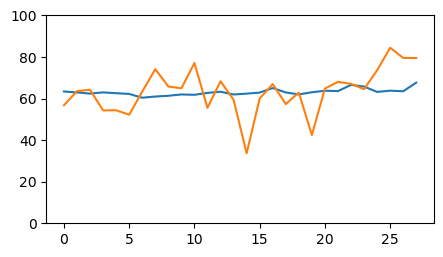

In [33]:
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(prediction)
ax.plot(O3)
ax.set_ylim([0, 100])
plt.show()

In [47]:
print("max difference = ", np.max(np.abs(prediction - O3)), "=", np.max(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% "
      "mean difference = " ,np.mean(np.abs(prediction - O3)), "=" , np.mean(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% ")

max difference =  28.688492 = 3.7122946 % mean difference =  7.7279673 = 1.0 % 


Kaggle

In [48]:
df = pd.read_csv('data/kaggle/onehr.data.xls')

In [18]:
df.columns = ["Date","WSR0","WSR1","WSR2","WSR3","WSR4","WSR5","WSR6","WSR7","WSR8","WSR9","WSR10","WSR11","WSR12","WSR13","WSR14","WSR15","WSR16","WSR17","WSR18","WSR19","WSR20","WSR21","WSR22","WSR23","WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70","U70","V70","HT70","T50","RH50","U50","V50","HT50","KI","TT","SLP","SLP_","Precp","Target"]

In [19]:
df

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Target
0,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
2,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
3,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
4,1/6/1998,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,...,0.09,11.98,11.28,5770,27.95,46.25,10120,?,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2531,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2532,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2533,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [20]:
data = nc.Dataset('data/2/adaptor.cams_regional_fc.retrieve-1706511910.699155-19398-7-0139e086-561b-430a-ad16-805bf0c3497a.nc')

In [21]:
data.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [22]:
data['o3_conc']

<class 'netCDF4._netCDF4.Variable'>
float32 o3_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Ozone
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_ozone_in_air
unlimited dimensions: time
current shape = (1, 10, 3, 3)
filling on

In [23]:
data['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [24]:
data['level']

<class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    long_name: level
    units: m
unlimited dimensions: 
current shape = (10,)
filling on, default _FillValue of 9.969209968386869e+36 used